In [ ]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import backend as K

from google.colab import files

In [ ]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

Cloning into 'COVID-19'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 60368 (delta 0), reused 2 (delta 0), pack-reused 60362
Receiving objects: 100% (60368/60368), 513.09 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (38345/38345), done.
Checking out files: 100% (708/708), done.
2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-10-23    95868
2020-10-24    96599
2020-10-25    97095
2020-10-26    97503
2020-10-27    98146
Name: 151, Length: 280, dtype: int64


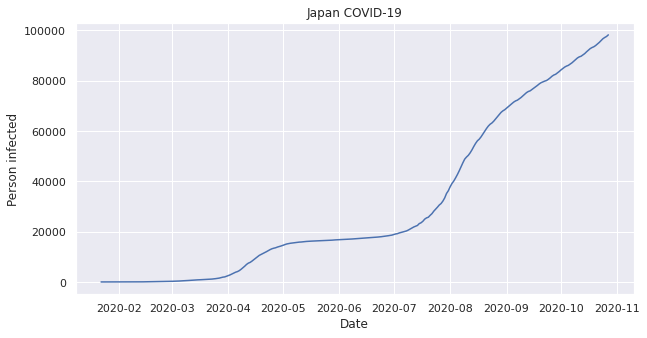

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date")
plt.ylabel("Person infected")
plt.grid(True)
plt.show()

In [ ]:
#ファイル保存
fname ='original.png'
plt.savefig(fname) 
plt.close() 

In [ ]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff = data_at_japan_diff.dropna()
data_at_japan_diff

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-10-23    734.0
2020-10-24    731.0
2020-10-25    496.0
2020-10-26    408.0
2020-10-27    643.0
Name: 151, Length: 279, dtype: float64

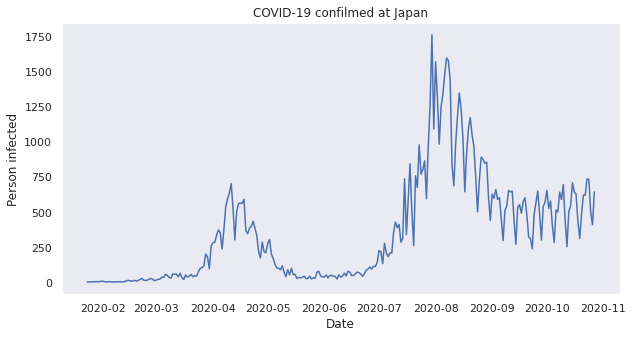

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel('Date')
plt.ylabel('Person infected')
plt.grid()
plt.show()

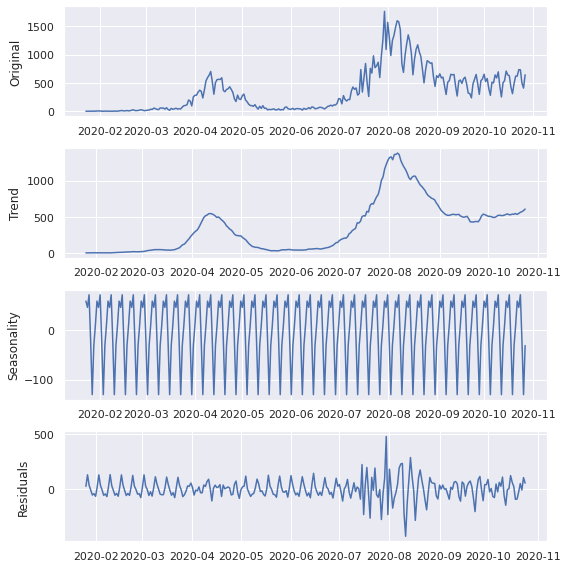

In [ ]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [ ]:
y = data_at_japan_diff.values.astype(float)
test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

In [ ]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

In [ ]:
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
window = 7#学習時のウィンドウサイズ
study_data, correct_data  = sequence_creator(train_normalized, window)
study_data1, correct_data1 = split_sequence(train_normalized, window)

In [ ]:
print(study_data.shape)
print(correct_data.shape)

(265, 7, 1)
(265, 1)


In [ ]:
study_data = np.squeeze(study_data)
correct_data = np.squeeze(correct_data)

In [ ]:
print(study_data.shape)
print(correct_data.shape)

(265, 7)
(265,)


In [ ]:
in_out_neurons = 1
n3_hidden=32

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
model = Sequential()
model.add(Dense(n3_hidden,input_dim=7,activation='relu',kernel_initializer='he_normal'))
# model4.add(Dropout(0.5))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.01, beta_1=0.9,beta_2=0.999,amsgrad=False)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["mae",rmse])# optimizer="rmsprop"
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
# reduce_lr = ReduceLROnPlateau(
#                         monitor='val_loss',
#                         factor=0.5,
#                         patience=2,
#                         min_lr=0.00001
#                 )
epochs=100#200
history = model.fit(study_data, correct_data, batch_size=1, epochs=epochs, validation_split=0.1, verbose=1,callbacks=[])#32

Epoch 1/100
238/238 [==============================] - 0s 2ms/step - loss: 0.0957 - mae: 0.2022 - rmse: 0.2022 - val_loss: 0.0266 - val_mae: 0.1172 - val_rmse: 0.1172
Epoch 2/100
238/238 [==============================] - 0s 955us/step - loss: 0.0305 - mae: 0.1164 - rmse: 0.1164 - val_loss: 0.0215 - val_mae: 0.1274 - val_rmse: 0.1274
Epoch 3/100
238/238 [==============================] - 0s 1ms/step - loss: 0.0353 - mae: 0.1261 - rmse: 0.1261 - val_loss: 0.0184 - val_mae: 0.1207 - val_rmse: 0.1207
Epoch 4/100
238/238 [==============================] - 0s 983us/step - loss: 0.0219 - mae: 0.1015 - rmse: 0.1015 - val_loss: 0.0190 - val_mae: 0.1237 - val_rmse: 0.1237
Epoch 5/100
238/238 [==============================] - 0s 967us/step - loss: 0.0221 - mae: 0.0997 - rmse: 0.0997 - val_loss: 0.0180 - val_mae: 0.1170 - val_rmse: 0.1170
Epoch 6/100
238/238 [==============================] - 0s 926us/step - loss: 0.0237 - mae: 0.1042 - rmse: 0.1042 - val_loss: 0.0208 - val_mae: 0.1234 - val_rms

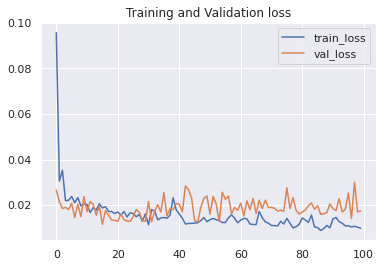

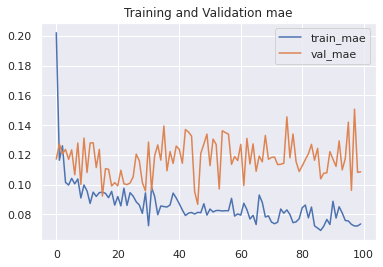

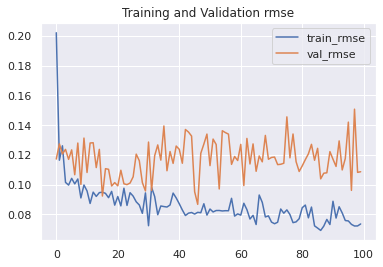

In [ ]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(np.arange(len(train_mae)), train_mae, label="train_mae")
plt.plot(np.arange(len(val_mae)), val_mae, label="val_mae")
plt.title('Training and Validation mae')
#plt.ylim((0, 0.1))#add
plt.legend()
plt.show()

train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

plt.plot(np.arange(len(train_loss)), train_rmse, label="train_rmse")
plt.plot(np.arange(len(val_loss)), val_rmse, label="val_rmse")
plt.title('Training and Validation rmse')
plt.legend()
plt.show()

In [ ]:
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

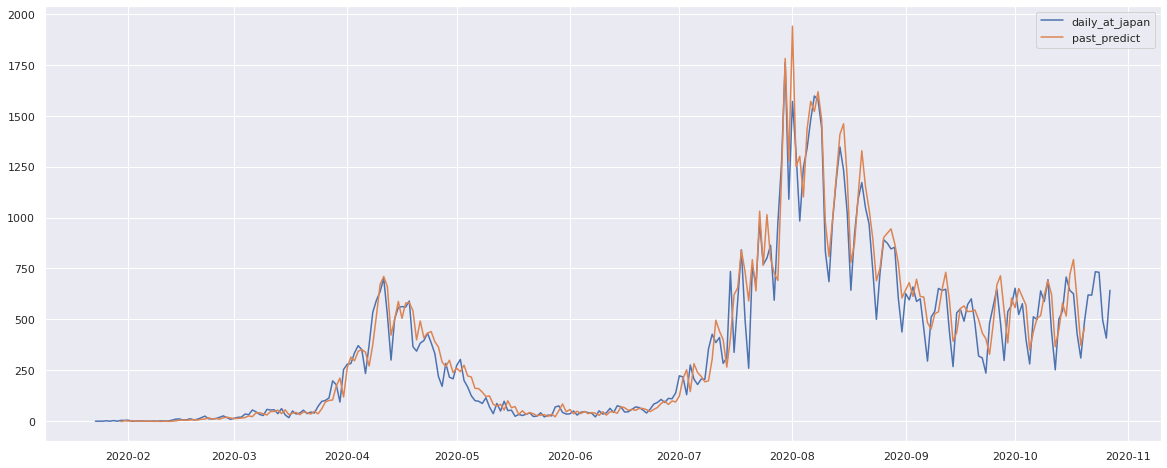

In [ ]:
plt.figure(figsize=(20,8))#サンプル数が多いので通常のpltでは表示がおかしくなるので適当な引数を渡して拡大表示
x0 = np.arange('2020-01-23','2020-10-14', dtype='datetime64[D]').astype('datetime64[D]')
plt.plot(data_at_japan_diff, label='daily_at_japan')
plt.plot(x0+7,train_inverse,label='past_predict')
plt.legend()

In [ ]:
upcoming_future=7

In [ ]:
predictions = train_normalized[-window:].tolist()
# predictions = np.array(predictions).reshape(-1)
predictions = np.array(predictions).reshape(-1, window, 1)
print(predictions.shape)
# predictions = np.squeeze(predictions)
# print(predictions.shape)

for i in range(upcoming_future):
  predicted_future = model.predict(predictions)
  with open("in_out.txt",mode="a", encoding= "utf-8") as f:
    f.write("input to model:" + str(predictions) )
    f.write("output from model:" + str(predicted_future) )
  predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  predictions = predictions[-window:]
  predictions = np.array(predictions).reshape(-1, window, 1)

(1, 7, 1)


ValueError: ignored

In [ ]:
predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions_infected_pepole

array([[541.],
       [708.],
       [642.],
       [626.],
       [428.],
       [310.],
       [487.]])

In [ ]:
x_all =np.arange('2020-01-23','2020-10-28', dtype='datetime64[D]').astype('datetime64[D]')
x_past_predict = np.arange('2020-01-30','2020-10-21', dtype='datetime64[D]').astype('datetime64[D]')#23-26
x_train = np.arange('2020-01-23','2020-10-21', dtype='datetime64[D]').astype('datetime64[D]')
x_test = np.arange('2020-10-21', '2020-10-28', dtype='datetime64[D]').astype('datetime64[D]')

ValueError: ignored

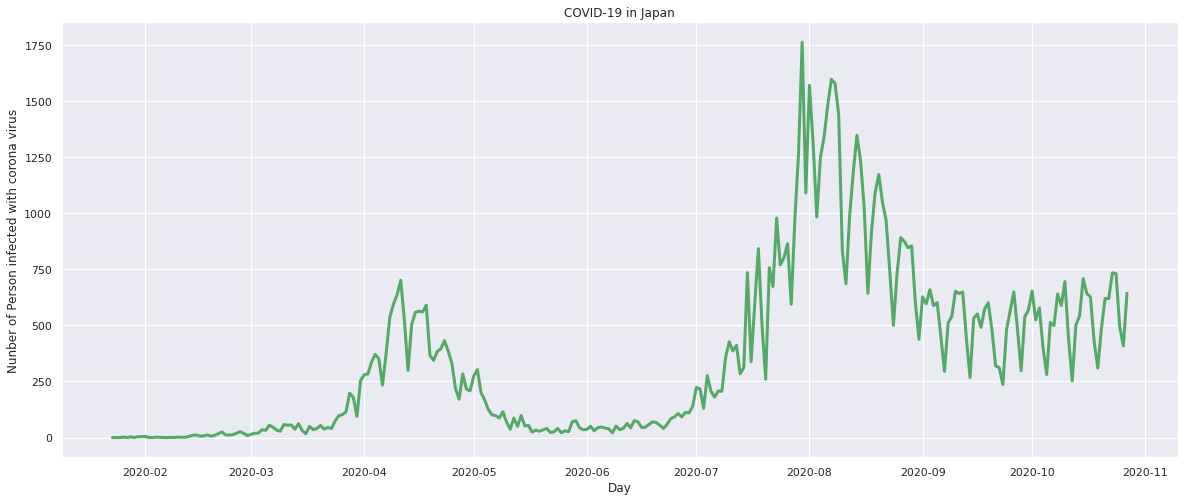

In [ ]:
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan")
plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Nunber of Person infected with corona virus")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
#plt.plot(x_train,train_original_data,label='train_data')
#plt.plot(x_test,test_original_data,label='test_data')
plt.plot(x_past_predict,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')#+8かも
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()

In [ ]:
train_data = train_original_data[7:]

train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train')
print('____________________________')
print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))
print('test')
print('____________________________')
print('test_mae:'+str(test_mae))
print('test_mse:'+str(test_mse))
print('test_rmae:'+str(test_rmse))
print('test_r2:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train
____________________________
train_mae:81.70639150367593
train_mse:10211.706646245848
train_rmae:101.05298929891113
train_r2:0.9278473687092332
test
____________________________
test_mae:98.14285714285714
test_mse:10316.428571428574
test_rmae:101.56982116469722
test_r2:0.15076573125823167
